In [3]:
!pip install obspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 20.9 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for obspy: filename=obspy-1.4.0-cp311-cp311-macosx_11_0_arm64.whl size=14045226 sha256=b0660081d6f694270872ea7d7e0804ea8de4fc8e4427417623c4a5c2a30c861b
  Stored in directory: /Users/margarita.shnaider/Library/Caches/pip/wheels/8b/7d/9b/c21e4534fec78fd69a71b5bbcc6017fcaccaf618a482f77212
Successfully built obspy


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from obspy.signal.detrend import polynomial
import obspy

In [9]:
#list the files
filelist = os.listdir("rr_data")
#read them into pandas
df_list = [pd.read_csv(f'rr_data/{file}',delimiter = "\t",names=[f'{file}']) for file in filelist]
print(df_list)

[        003.txt
0           718
1           672
2           688
3           672
4           664
...         ...
108145      555
108146      547
108147      539
108148      531
108149      531

[108150 rows x 1 columns],        002.txt
0          735
1          781
2          742
3          680
4          758
...        ...
68024      524
68025      593
68026      602
68027      672
68028      672

[68029 rows x 1 columns],        000.txt
0          789
1          727
2          789
3          750
4          812
...        ...
80436      649
80437      695
80438      727
80439      703
80440      703

[80441 rows x 1 columns],         011.txt
0           539
1           539
2           547
3           539
4           539
...         ...
110506      781
110507      773
110508      813
110509      843
110510      843

[110511 rows x 1 columns],        005.txt
0          797
1          843
2          829
3          828
4          859
...        ...
97920      766
97921      797
97922     

In [11]:
min_len = min(map(len, df_list))
print(min_len)
#to even the all txt files cropping them
small_df = pd.concat(df_list,axis=1)
big_df = (small_df.T).apply(pd.to_numeric, errors='coerce')
cropped_df = big_df.iloc[:,:min_len]
print(cropped_df)

57333
         0      1      2      3      4      5      6       7      8      \
003.txt  718.0  672.0  688.0  672.0  664.0  625.0  617.0   617.0  617.0   
002.txt  735.0  781.0  742.0  680.0  758.0  695.0  680.0   679.0  625.0   
000.txt  789.0  727.0  789.0  750.0  812.0  789.0  828.0   797.0  867.0   
011.txt  539.0  539.0  547.0  539.0  539.0  531.0  539.0   539.0  539.0   
005.txt  797.0  843.0  829.0  828.0  859.0  859.0  875.0   875.0  922.0   
010.txt  984.0  969.0  969.0  922.0  937.0  961.0  992.0  1000.0  930.0   
006.txt  844.0  813.0  781.0  773.0  789.0  797.0  797.0   758.0  727.0   
013.txt  664.0  665.0  656.0  672.0  672.0  656.0  656.0   641.0  601.0   
007.txt  704.0  710.0  727.0  734.0  735.0  719.0  710.0   719.0  703.0   
009.txt  641.0  633.0  640.0  657.0  648.0  649.0  632.0   633.0  641.0   
008.txt  758.0  774.0  789.0  781.0  687.0  672.0  680.0   727.0  836.0   

         9      ...   57323   57324   57325   57326   57327   57328   57329  \
003.txt  633.0

In [26]:
#separating the dataframe into 2 batches
batch1 = cropped_df.iloc[:,:int(cropped_df.shape[1]/2)]
batch2 = cropped_df.iloc[:,int(cropped_df.shape[1]/2):]
print(batch1)
print(batch2)

         0      1      2      3      4      5      6       7      8      \
003.txt  718.0  672.0  688.0  672.0  664.0  625.0  617.0   617.0  617.0   
002.txt  735.0  781.0  742.0  680.0  758.0  695.0  680.0   679.0  625.0   
000.txt  789.0  727.0  789.0  750.0  812.0  789.0  828.0   797.0  867.0   
011.txt  539.0  539.0  547.0  539.0  539.0  531.0  539.0   539.0  539.0   
005.txt  797.0  843.0  829.0  828.0  859.0  859.0  875.0   875.0  922.0   
010.txt  984.0  969.0  969.0  922.0  937.0  961.0  992.0  1000.0  930.0   
006.txt  844.0  813.0  781.0  773.0  789.0  797.0  797.0   758.0  727.0   
013.txt  664.0  665.0  656.0  672.0  672.0  656.0  656.0   641.0  601.0   
007.txt  704.0  710.0  727.0  734.0  735.0  719.0  710.0   719.0  703.0   
009.txt  641.0  633.0  640.0  657.0  648.0  649.0  632.0   633.0  641.0   
008.txt  758.0  774.0  789.0  781.0  687.0  672.0  680.0   727.0  836.0   

         9      ...   28656   28657   28658   28659   28660   28661   28662  \
003.txt  633.0  ... 

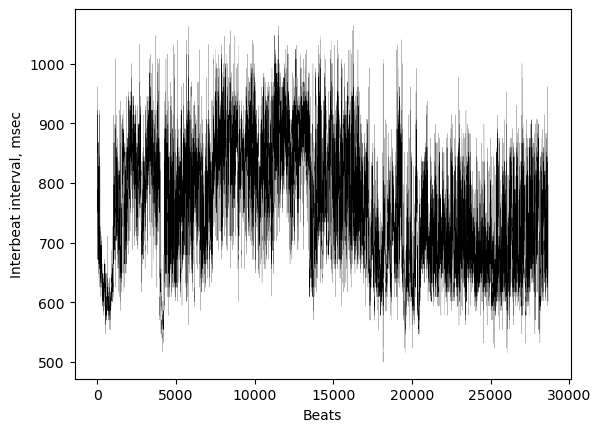

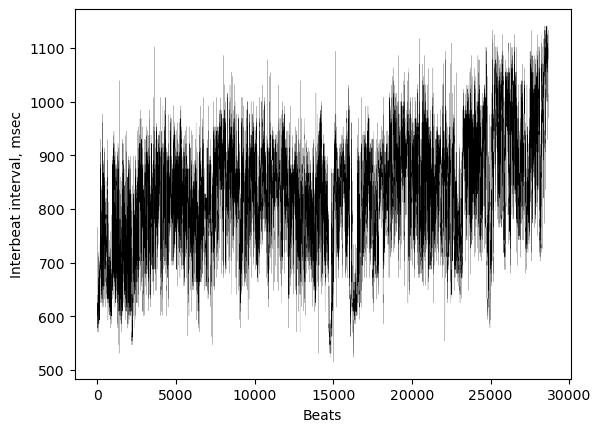

In [79]:
def reject_outliers(data):
    cleaned_rows = [] 
    N = data.shape[0]
    for i in range(N):
        
        row_data = data.iloc[i, :]

        row_mean = np.mean(row_data)
        row_std = np.std(row_data)
    
        threshold = 3
        lower_bound = row_mean - threshold * row_std
        upper_bound = row_mean + threshold * row_std
    
        outliers = np.logical_or(row_data < lower_bound, row_data > upper_bound)
    
        cleaned_row = np.where(outliers, np.nan, row_data)
        
        cleaned_rows = np.array(cleaned_row)

    cleaned_data = np.array(cleaned_rows)
    return cleaned_data


batch1_clean = reject_outliers(batch1)
plt.plot(batch1_clean, color = 'black', linewidth=0.1)
plt.xlabel('Beats')
plt.ylabel('Interbeat interval, msec')
plt.show()

batch2_clean = reject_outliers(batch2)
plt.plot(batch2_clean, color = 'black', linewidth=0.1)
plt.xlabel('Beats')
plt.ylabel('Interbeat interval, msec')
plt.show()

In [60]:
df_cum = batch1.cumsum(axis = 1, skipna = True)
N = batch1.shape[1]

#defining a detrending function to find delta
def detrend(df, s_vals, p_order):
    for j in range(len(df)):
      row = df.iloc[j,:]
      delta_S_B=np.zeros((len(s_vals),N))
      for idx, s in enumerate(s_vals):
        intval = int(np.floor(N/(2*s)))
        for i in range(intval):
          #print(row[i*2*s:(i+1)*2*s])
          polynomial(row[i*2*s:(i+1)*2*s],p_order, plot =False)
        polynomial(row[intval*2*s:],p_order, plot =False)
        print(row[i+s])
        delta_S_B[idx,:]=np.array([row[i+s]-row[i] if i+s< N else row[i] for i in range(N)])
    return delta_S_B

delta_S_B = detrend(df_cum[0:3],[1000], 3)
print(delta_S_B)
#print(delta_S_B)
#plt.plot(np.linspace(0,N,N), delta_S_B[0,:])
#counts, edges=np.histogram(delta_S_B[0,:], bins=int(np.sqrt(delta_S_B[0,:].size)), range=(-10, 10))
#bin_cen=(edges[1:]+edges[:-1])/2
#plt.scatter(bin_cen, counts, s=1)

-3754.823046023026
-900.0930683825864
-2274.689085802762
[[-466.5447658  -226.95588231  -80.43826785 ...  275.45615122
   236.49897601  212.39045408]]
